In [1]:
import os 
import warnings
import pickle
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras.utils as image

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


In [2]:

files = listdir("Data/Random Sample/")
print(len(files))

100


In [3]:
base_path = "Data/Random Sample/"
folder = listdir(base_path)
# folder

In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [5]:
total_images

95808

In [6]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0       9036  Data/Random Sample/9036/0/9036_idx5_x1051_y240...      0
1       9036  Data/Random Sample/9036/0/9036_idx5_x2951_y951...      0
2       9036  Data/Random Sample/9036/0/9036_idx5_x3001_y145...      0
3       9036  Data/Random Sample/9036/0/9036_idx5_x3051_y801...      0
4       9036  Data/Random Sample/9036/0/9036_idx5_x951_y1901...      0

In [7]:
data.shape

(95808, 3)

In [8]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

In [9]:
cancer_perc

target             0         1
patient_id                    
10257       0.672441  0.327559
10259       0.978840  0.021160
10261       0.913313  0.086687
10262       0.582734  0.417266
10268       0.989094  0.010906
...              ...       ...
9324        0.690979  0.309021
9345        0.467511  0.532489
9347        0.875610  0.124390
9381        0.903469  0.096531
9382        0.790557  0.209443

[100 rows x 2 columns]

Text(0.5, 1.0, 'How many patches show IDC?')

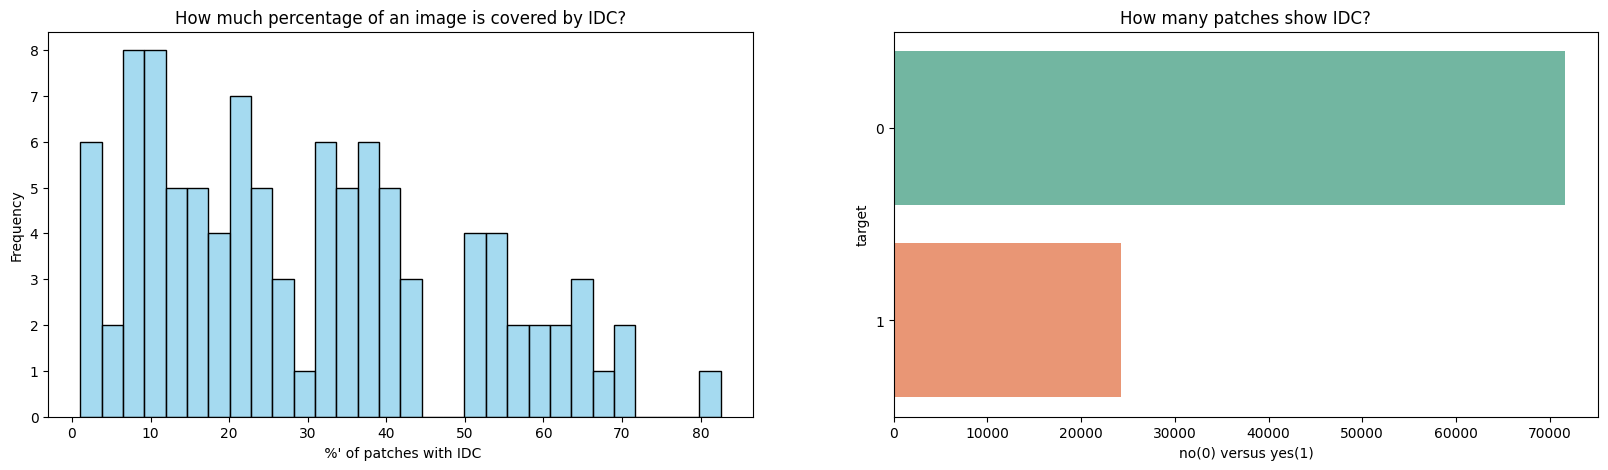

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[0], color="Skyblue", kde=False, bins=30)
ax[0].set_title("How much percentage of an image is covered by IDC?")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel(" %' of patches with IDC")
sns.countplot(data.target, palette="Set2", ax=ax[1])
ax[1].set_xlabel("no(0) versus yes(1)")
ax[1].set_title("How many patches show IDC?")

In [13]:
data.target = data.target.astype(int)

In [14]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

Showcasing Cancer Patches


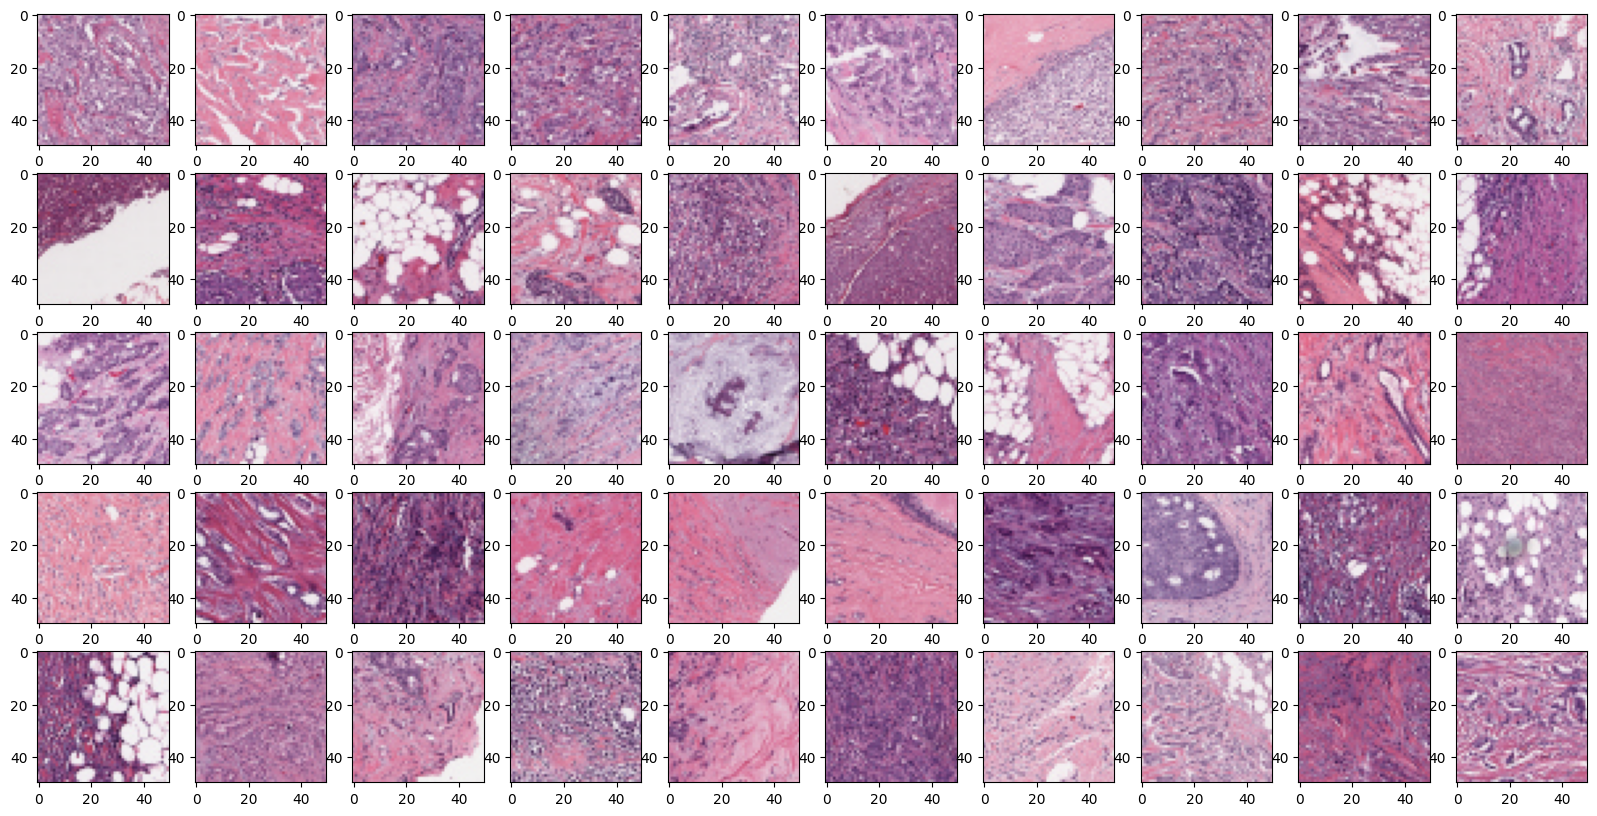

In [15]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

print("Showcasing Cancer Patches")
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Showcasing Healthy Patches


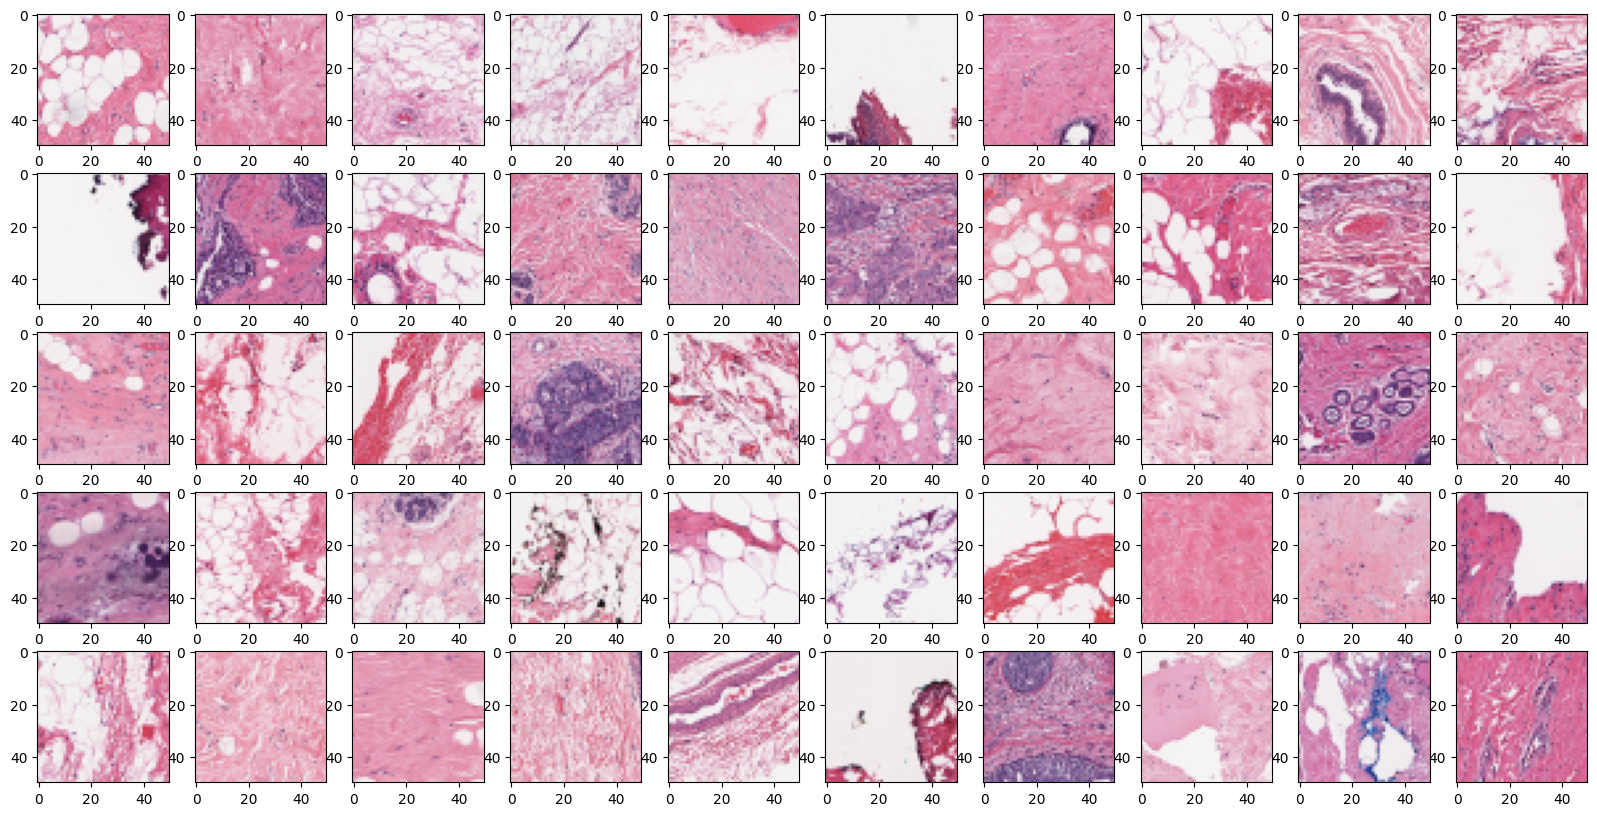

In [16]:

fig, ax = plt.subplots(5,10,figsize=(20,10))

print("Showcasing Healthy Patches")
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [17]:
torch.manual_seed(0)
np.random.seed(0)

In [18]:
data.head()
data.loc[:, "target"] = data.target.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95808 entries, 0 to 95807
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  95808 non-null  object
 1   path        95808 non-null  object
 2   target      95808 non-null  object
dtypes: object(3)
memory usage: 4.9+ MB


----------------

#TENSORFLOW IMPLIMENTATION

In [2]:
data_paths = glob('Data/Random Sample/**/*.png', recursive=True)
len(data_paths)

95808

In [3]:
images=[]
labels=[]
for i in data_paths:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(50,50))
        images.append(img_1)
        labels.append(label)

In [4]:
x=np.stack(images)

In [5]:
x.shape

(95808, 50, 50, 3)

In [6]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(labels)

In [7]:
value_counts = np.sum(y, axis=0)

print("Percentage of Non-cancer images:")
print(value_counts[0]/sum(value_counts))

print("Percentage of cancer images:")
print(value_counts[1]/sum(value_counts))

Percentage of Non-cancer images:
0.7471505511022044
Percentage of Non-cancer images:
0.2528494488977956


In [8]:
x=x/255

In [9]:
x

array([[[[0.83137255, 0.75686275, 0.89803922],
         [0.8745098 , 0.79215686, 0.91372549],
         [0.79215686, 0.72156863, 0.88627451],
         ...,
         [0.84705882, 0.78039216, 0.89803922],
         [0.85490196, 0.80392157, 0.89803922],
         [0.76470588, 0.66666667, 0.87058824]],

        [[0.78823529, 0.69019608, 0.87843137],
         [0.83137255, 0.78039216, 0.90196078],
         [0.91372549, 0.85882353, 0.94117647],
         ...,
         [0.71764706, 0.63137255, 0.85490196],
         [0.87843137, 0.84313725, 0.92156863],
         [0.9372549 , 0.90196078, 0.95294118]],

        [[0.69411765, 0.55294118, 0.81568627],
         [0.74117647, 0.61568627, 0.84313725],
         [0.82352941, 0.71764706, 0.8745098 ],
         ...,
         [0.78823529, 0.71372549, 0.88235294],
         [0.83921569, 0.76078431, 0.89019608],
         [0.85098039, 0.77647059, 0.89411765]],

        ...,

        [[0.95294118, 0.94901961, 0.95686275],
         [0.95294118, 0.94117647, 0.95686275]

In [10]:
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test= train_test_split(x,y,random_state=0,test_size=0.2, stratify=y)

In [17]:
# import pickle
# # Save x_train
# with open('x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)

# # Save x_test
# with open('x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)

# # Save y_train
# with open('y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)

# # Save y_test
# with open('y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)


In [ ]:
# Load x_train
with open('x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)

# Load x_test
with open('x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)

# Load y_train
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load y_test
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


In [11]:
x_train.shape

(76646, 50, 50, 3)

In [12]:
x_test.shape

(19162, 50, 50, 3)

In [16]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
def modelEfficientNetB0():
    
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = "imagenet",
                            input_shape=(50,50, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation = "sigmoid"))
    
    return model 
model = modelEfficientNetB0()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [23]:
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-5
# opt = Adam(learning_rate = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [24]:
history=model.fit(x,y,epochs=10,validation_split=0.4,batch_size=64) #256 or closer

Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 287s 300ms/step - acc: 0.8585 - loss: 0.3320 - val_acc: 0.8289 - val_loss: 0.3847
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 303s 337ms/step - acc: 0.8989 - loss: 0.2376 - val_acc: 0.8231 - val_loss: 0.5235
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 316s 351ms/step - acc: 0.9102 - loss: 0.2148 - val_acc: 0.8169 - val_loss: 0.6591
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 333s 370ms/step - acc: 0.9208 - loss: 0.1873 - val_acc: 0.8362 - val_loss: 0.5351
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 317s 352ms/step - acc: 0.9323 - loss: 0.1644 - val_acc: 0.8356 - val_loss: 0.5591
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 335s 373ms/step - acc: 0.9399 - loss: 0.1457 - val_acc: 0.8409 - val_loss: 0.5663
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 321s 357ms/step - acc: 0.9513 - loss: 0.1192 - val_acc: 0.8339 - val_loss: 0.6105
Epoch 8/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 316s 351ms/step - acc: 0.9602 - loss: 0.1018 - val_acc: 0.8239 - val_loss: 0.6767
Epoch 9/10
899/899 ━━━━━

In [25]:
loss,accuracy=model.evaluate(x_test,y_test)

599/599 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - acc: 0.8962 - loss: 0.5082


In [26]:
accuracy

0.8969836235046387

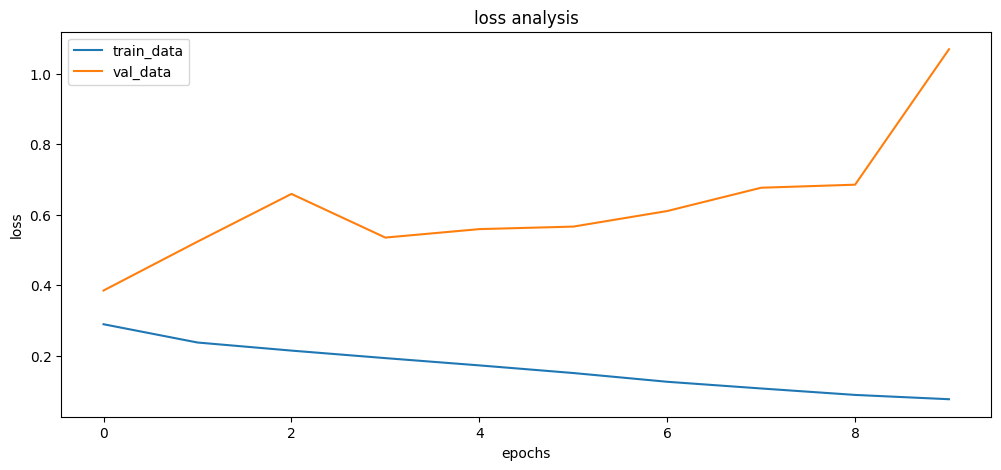

In [27]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data','val_data'])
plt.title('loss analysis')
plt.show()

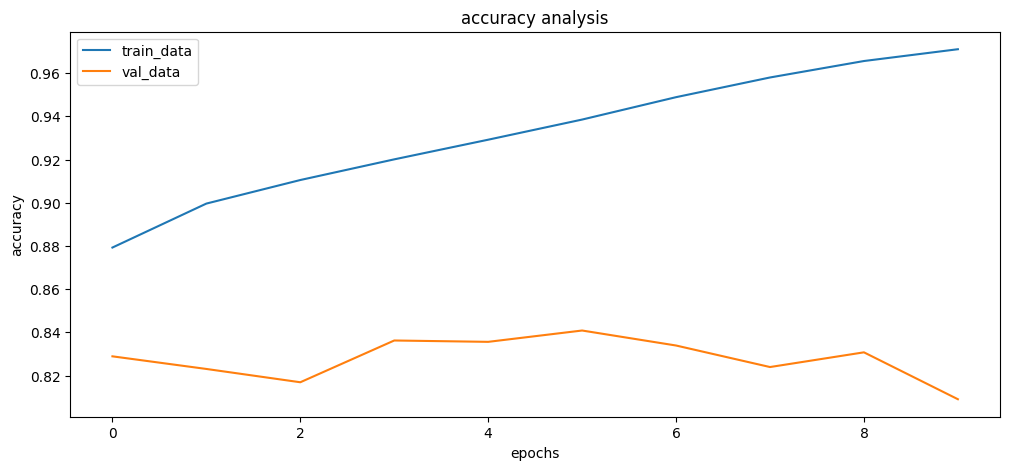

In [28]:
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data','val_data'])
plt.title('accuracy analysis')
plt.show()

In [31]:
model.save("effecientb0.keras")
